In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 18.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import datetime 
import pandas as pd

start_train = datetime.datetime(2014,1,1) 
end_train = datetime.datetime(2021,9,1) 

# type: data frame
train_data = yf.download(tickers='BTC-USD', start=start_train, end=end_train)

[*********************100%***********************]  1 of 1 completed


In [ ]:
test_data = yf.download(tickers='BTC-USD', start=end_train)

[*********************100%***********************]  1 of 1 completed


In [ ]:
train_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


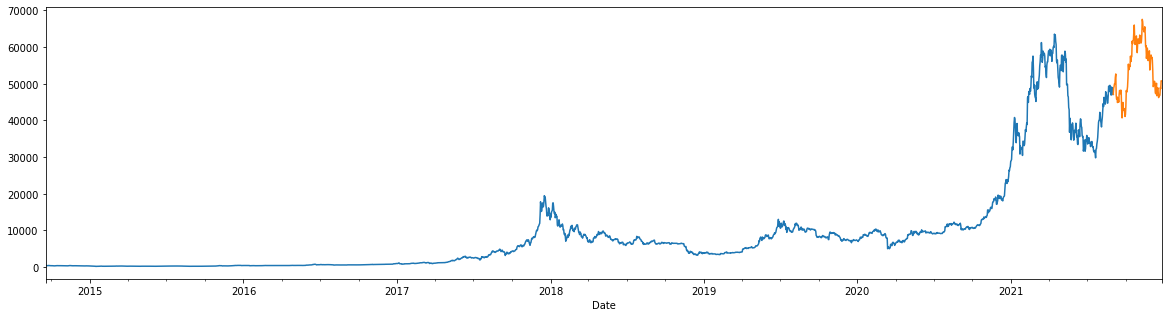

In [ ]:
ax = train_data['Open'].plot(figsize=(20,5))
test_data['Open'].plot(ax=ax)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# normalize train and test data with sklearn.preprocessing.MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data['Open'].values.reshape(-1, 1))
train_normalized = scaler.transform(train_data['Open'].values.reshape(-1, 1))
train_normalized = np.squeeze(train_normalized)

scaler2 = MinMaxScaler()
scaler2.fit(test_data['Open'].values.reshape(-1, 1))
test_normalized = scaler2.transform(test_data['Open'].values.reshape(-1, 1))
test_normalized = np.squeeze(test_normalized)

print("train sequence shape", train_normalized.shape)
print("test sequence shape", test_normalized.shape)
print(train_normalized[2400])
print(test_normalized[50])

train sequence shape (2542,)
test sequence shape (116,)
0.9426374953289349
0.9424117074486829


In [ ]:
past = 60
x_train = []
y_train = []

# prepocess data
for i in range(train_normalized.size-past):
  x = train_normalized[i:i+past]
  y = train_normalized[i+past]
  x_train.append(x)
  y_train.append(y)

x_train = np.array(x_train)
x_train = np.expand_dims(x_train, axis=-1)
print(x_train.shape)

y_train = np.array(y_train)
print(y_train.shape)  

(2482, 60, 1)
(2482,)


In [ ]:
x_test = []
y_test = []

for i in range(test_normalized.size-past):
  x = test_normalized[i:i+past]
  y = test_normalized[i+past]
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
x_test = np.expand_dims(x_test, axis=-1)
print(x_test.shape)

y_test = np.array(y_test)
print(y_test.shape)

(56, 60, 1)
(56,)


In [ ]:
batch_size = 32
epoch_size = 100

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(past, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=epoch_size, batch_size=batch_size)

Epoch 1/100
78/78 [==============================] - 15s 64ms/step - loss: 0.0048
Epoch 2/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0016
Epoch 3/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0013
Epoch 4/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0013
Epoch 5/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0012
Epoch 6/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0010
Epoch 7/100
78/78 [==============================] - 5s 62ms/step - loss: 9.1208e-04
Epoch 8/100
78/78 [==============================] - 5s 62ms/step - loss: 9.0209e-04
Epoch 9/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0010
Epoch 10/100
78/78 [==============================] - 5s 62ms/step - loss: 7.7706e-04
Epoch 11/100
78/78 [==============================] - 5s 62ms/step - loss: 7.0344e-04
Epoch 12/100
78/78 [==============================] - 5s 62ms/step - loss: 8.0887e-04
Epoc

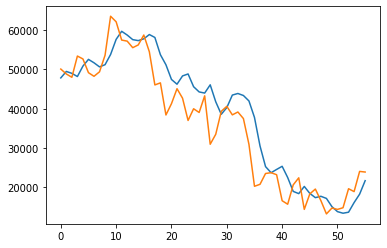

In [ ]:
import matplotlib.pyplot as plt

# predict test data to check the performance of model
pred_norm = model.predict(x_test)
# print(pred_norm.shape)

# inverse of normalize
# to find true values
test_pred_val = np.squeeze(scaler.inverse_transform(pred_norm))
y_test_val = np.squeeze(scaler.inverse_transform([y_test]))
# plot true labels of test data and prediction
plt.plot(test_pred_val)
plt.plot(y_test_val)
plt.show()

In [ ]:
# predict next 3 months
future = 3 * 30
data = list(test_normalized[-past:])

future_preds = []
for i in range(future):
  data_batch = np.expand_dims(data, 0)
  prediction = model.predict(data_batch)[0][0]  
  future_preds.append(prediction)
  # remove first elemenet from data and append new prediction for next loop
  data.pop(0)
  data.append(prediction)

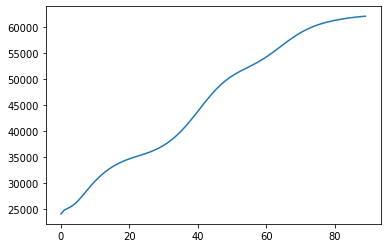

In [ ]:
future_preds = np.array(future_preds)
inv_pred = scaler.inverse_transform(future_preds.reshape(-1, 1))
plt.plot(np.squeeze(inv_pred))